In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from typing import Sequence
import tarfile
import io
import torch
import numpy as np
from omegaconf import DictConfig
from tqdm import tqdm
from datasets.video import OpticalFlowVideoDataset
import torch
from torchvision.utils import flow_to_image
from unittest.mock import MagicMock
import tqdm 
from algorithms.diffusion_forcing import DiffusionForcingFlow

import mediapy as media
from einops import rearrange

/home/iyu/miniconda3/envs/diff-force/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = np.load("/home/iyu/diffusion-forcing/data/rod_flow/training/right.pkl.npz")

media.show_video(data["birdview_rgb"], fps=30)

In [4]:
from torchvision.utils import flow_to_image
H, W = data["flow"].shape[-2], data["flow"].shape[-1]

flows = flow_to_image(torch.from_numpy(data["flow"]))
#flows = torch.nn.functional.interpolate(flows, (H, W))
flows = rearrange(flows, "... c h w -> ... h w c")
flows = flows.numpy()
media.show_video(flows, fps=30)
#media.show_image(flows)

4900
dataset item shapes torch.Size([1, 2, 256, 256]) torch.Size([1, 3, 256, 256]) (1,)
torch.Size([256, 256, 3])


""

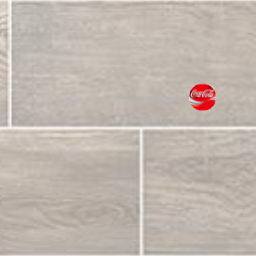

In [6]:
cfg = MagicMock()
cfg.resolution = 256
cfg.external_cond_dim = 0
cfg.n_frames = 1
cfg.frame_skip = 1
cfg.save_dir = "/home/iyu/diffusion-forcing/data/rod_flow"
cfg.validation_multiplier = 1
cfg.frame_stack = 1

dataset = OpticalFlowVideoDataset(cfg, "training")
print(len(dataset))

flow, vid, term = dataset[60]
print("dataset item shapes", flow.shape, vid.shape, term.shape)

data_mean = torch.tensor(0.5)
data_std = torch.tensor(0.5)

def _normalize_x(xs: torch.Tensor) -> torch.Tensor:
    shape = [1] * (xs.ndim - data_mean.ndim) + list(data_mean.shape)
    mean = data_mean.reshape(shape)
    std = data_std.reshape(shape)
    return (xs - mean) / std

def _unnormalize_x(xs: torch.Tensor) -> torch.Tensor:
    shape = [1] * (xs.ndim - data_mean.ndim) + list(data_mean.shape)
    mean = data_mean.reshape(shape)
    std = data_std.reshape(shape)
    return xs * std + mean

def _unstack_and_unnormalize(xs: torch.Tensor) -> torch.Tensor:
    xs = rearrange(xs, "t b (fs c) ... -> (t fs) b c ...", fs=1)
    return _unnormalize_x(xs)

vid_np = rearrange(vid[0], "... c h w -> ... h w c")
print(vid_np.shape)

xs = _normalize_x(flow)
xs = rearrange(xs, "(t fs) c ... -> t (fs c) ...", fs=1).contiguous()
xs = _unstack_and_unnormalize(xs)

H, W = 256, 256
gt_img = flow_to_image(xs)
gt_img = torch.nn.functional.interpolate(gt_img, (H, W))

gt_img = rearrange(gt_img, "t c h w -> t h w c")
gt_img = gt_img[0].numpy()
media.show_image(vid_np)

In [3]:
# calculate mean and standard deviation of the dataset
right = np.load("/home/iyu/scene-jacobian-discovery/diff-force/diffusion-forcing/data/rod_flow/training/right.pkl.npz")
down = np.load("/home/iyu/scene-jacobian-discovery/diff-force/diffusion-forcing/data/pusher_down/training/down.pkl.npz")

right_flow = right["flow"][10:11]
down_flow = down["flow"][10:11]

#right_flow = np.concatenate([right_flow, down_flow], axis=0)

print("right flow shape", right_flow.shape)

ax_1_flow = right_flow[:, 0:1, :, :]
ax_2_flow = right_flow[:, 1:2, :, :]

right_mean_ax_1 = ax_1_flow.mean()
right_mean_ax_2 = ax_2_flow.mean()

right_std_ax_1 = ax_1_flow.std()
right_std_ax_2 = ax_2_flow.std()

print("right mean ax 1", right_mean_ax_1)
print("right mean ax 2", right_mean_ax_2)
print("right std ax 1", right_std_ax_1)
print("right std ax 2", right_std_ax_2)
print("right ax 1 min", ax_1_flow.min())
print("right ax 1 max", ax_1_flow.max())
print("right ax 2 min", ax_2_flow.min())
print("right ax 2 max", ax_2_flow.max())

right flow shape (1, 2, 256, 256)
right mean ax 1 0.1243762
right mean ax 2 0.0115535315
right std ax 1 1.1944656
right std ax 2 0.03058018
right ax 1 min -0.22534409
right ax 1 max 13.109137
right ax 2 min -2.4485154
right ax 2 max 0.45655122
